# ATHENA Tutorial on MIBI Data
Short introductory tutorial on MIBI data. For more detailed documentation and tutorials check out the docs: https://histocartography.github.io/athena/

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import spatialHeterogeneity as sh
from tqdm import tqdm
from spatialOmics import SpatialOmics

sel1 = ['14', '33']
sel2 = ['5', '35']
spls = sel1 + sel2

attr = 'group_id'

import warnings
warnings.filterwarnings("ignore")

## Data
Download the pre-processed data set. I combined the data from https://www.angelolab.com/mibi-data and https://mibi-share.ionpath.com/tracker/imageset (see [load-mibi-data.py]('./load-mibi-data.py'))

In [2]:
so = sh.dataset.mibi()
# so = sh.dataset.mibi_pop()  # load populated MIBI dataset, not yet uploaded
# so = SpatialOmics.from_h5py('mibi.h5py')

so

INFO:numexpr.utils:NumExpr defaulting to 8 threads.



SpatialOmics object with n_obs 197678
    X: 40, (2046, 8212) x (44, 44)
    spl: 40, ['class', 'cell_mask_file', 'tiff_stack_file']
    obs: 40, {'SampleID', 'cellSize', 'CD163', 'C', 'CSF-1R', 'tumorYN', 'B7H3', 'tumorCluster', 'cell_type', 'group', 'Group', 'immuneGroup', 'group_id', 'OX40', 'cell_type_id', 'immuneCluster'}
    var: 40, {'channel', 'stack_index'}
    G: 0, set()
    masks: 40, {'cellmasks'}
    images: 40

## Phenotypes

In [3]:
import pandas as pd
cont = []
for spl in so.spl.index:
    cont.append(so.obs[spl][['group', 'group_id']])
groups = pd.concat(cont)
groups = groups[~groups.duplicated()].sort_values('group_id').reset_index(drop=True)
groups

group  group_id
0    t6i0         0
1    t5i0         1
2    t4i0         2
3    t1i0         3
4    t3i0         4
5    t2i4         5
6    t2i6         6
7    t2i1         7
8    t2i9         8
9   t2i12         9
10   t2i8        10
11   t2i7        11
12  t2i11        12
13   t2i5        13
14  t2i10        14
15   t2i2        15
16   t2i3        16

## Colormaps

In [4]:
# %% generate colormaps
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.pyplot as plt
import colorcet as cc

so.uns['cmaps']['default'] = plt.get_cmap('plasma')

grp2id = groups.set_index('group').group_id.to_dict()

for spl in spls:
    so.obs[spl]['group_id'] = [grp2id[i] for i in so.obs[spl].group]
    so.obs[spl]['group_id'] = so.obs[spl].group_id.astype('category')

# select colormaps for tumor/immune cells
tmap = sns.color_palette(cc.glasbey_warm, n_colors=5)
imap = sns.color_palette(cc.glasbey_cool, n_colors=12)
palette = tmap + imap

so.uns['cmap_labels']['group_id'] = {j:i for i,j in grp2id.items()}
so.uns['cmaps']['group_id'] = ListedColormap(palette)

cmap = ['white', 'darkgreen', 'darkred']
cmap_labels = {0: 'background', 1: 'immune',  2:'tumor'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

cmap = ['darkgreen', 'darkred']
cmap_labels = {0: 'immune',  1:'tumor'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type': cmap})
so.uns['cmap_labels'].update({'cell_type': cmap_labels})

so.uns['cmaps'].update({'default': cm.plasma})

## Visualisation
Visualisations with the napari viewer

In [5]:
sh.pl.napari_viewer(so, '1', ['H3K25me3', 'dsDNA', 'CD45', 'Background'], attrs_key='channel',
                    index_key='stack_index')

so.uns['cmaps']['default'] = plt.get_cmap('plasma')
# to load all channels
# sh.pl.napari_viewer(so, '1', so.var['1'].channel, attrs_key='channel', index_key='stack_index')

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


## Pre-processing
Extract cellmask centroids from cellmasks. This is required for many plotting functionalities.

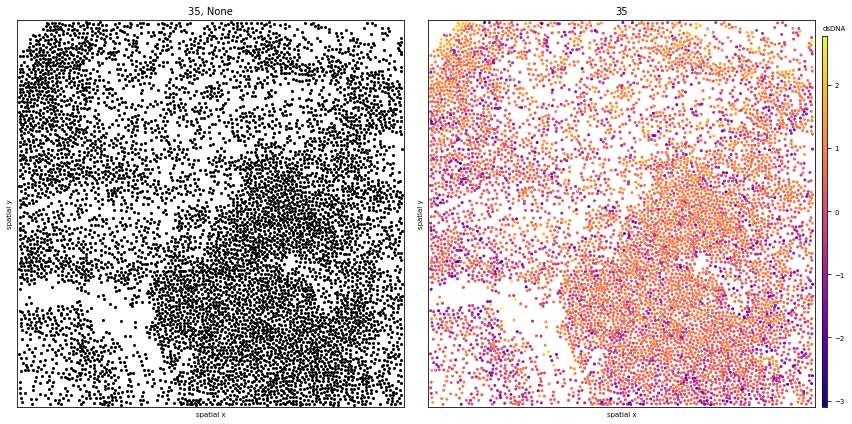

In [6]:
for spl in spls:
    if spl in so.masks:
        sh.pp.extract_centroids(so, spl)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sh.pl.spatial(so, spl, None, ax=axs[0])
sh.pl.spatial(so, spl, 'dsDNA', ax=axs[1])
fig.show()

## Graph construction
In a first step we compute the pair-wise distances between observations and plot a histogram to get an impression
of how the radius affects the number of neighbors.

Graph computations for the radius and knn graph topology are relatively cheap.
However, the contact graph topology is quite expensive to compute (~6h on my machine for all samples).

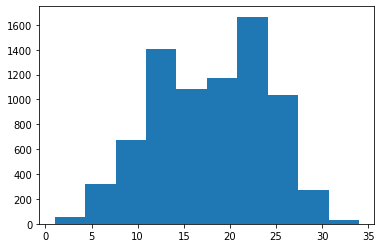

In [7]:
from scipy.spatial.distance import cdist
from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

# get an impression of the number of neighbors for different radii
df = so.obs[spl][['x', 'y']]
radius = 50
cell2cell_dists = cdist(df, df)
g = plt.hist((cell2cell_dists <= radius).sum(1))
plt.show()

config_radius = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config_radius['builder_params']['radius'] = radius


In [8]:
for spl in spls:
    if spl in so.masks:
        try:
            sh.graph.build_graph(so, spl, 'radius', config=config_radius)
            sh.graph.build_graph(so, spl, 'knn')
        except Exception as e:
            print(f'{spl} raised exception:\n{e}')

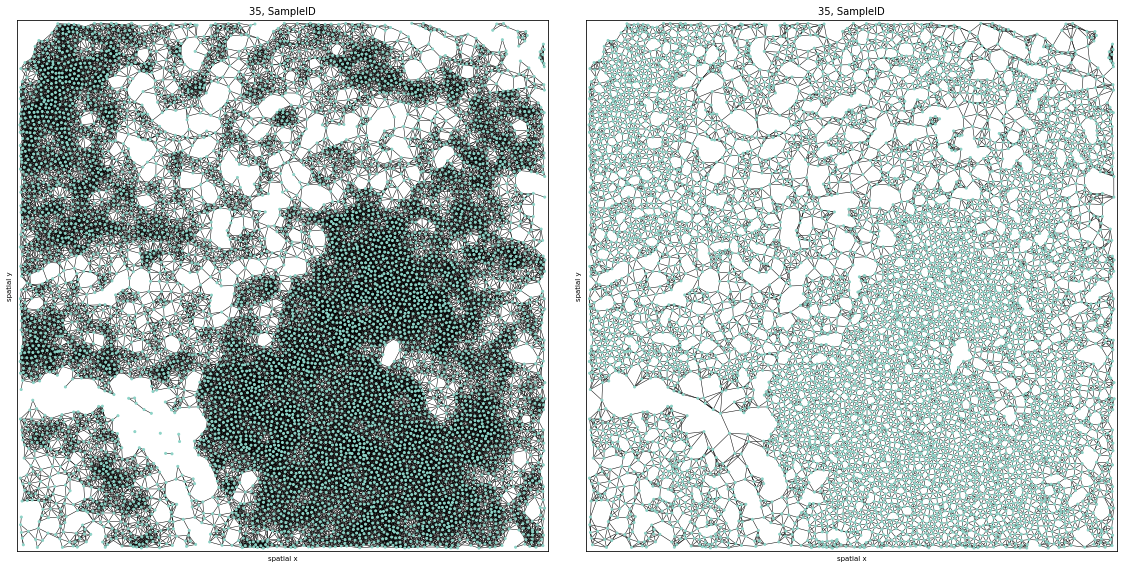

In [9]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))
sh.pl.spatial(so, spl, 'SampleID', edges=True, graph_key='radius', ax=axs[0], cbar=False)
sh.pl.spatial(so, spl, 'SampleID', edges=True, graph_key='knn', ax=axs[1], cbar=False)

## Entropic measures - Sample level
Here we compute the discussed sample-level entropic measures by setting `local=False`.

In [10]:
for spl in spls:
    sh.metrics.richness(so, spl, attr, local=False, graph_key='knn')
    sh.metrics.shannon(so, spl, attr, local=False, graph_key='knn')
    sh.metrics.quadratic_entropy(so, spl, attr, local=False, graph_key='knn')

# estimated values are saved in so.spl
so.spl.loc[spls][[f'richness_{attr}', f'shannon_{attr}']].head()

richness_group_id  shannon_group_id
SampleID                                     
14                     15.0          1.150927
33                     15.0          1.843142
5                      17.0          2.833134
35                     16.0          2.392072

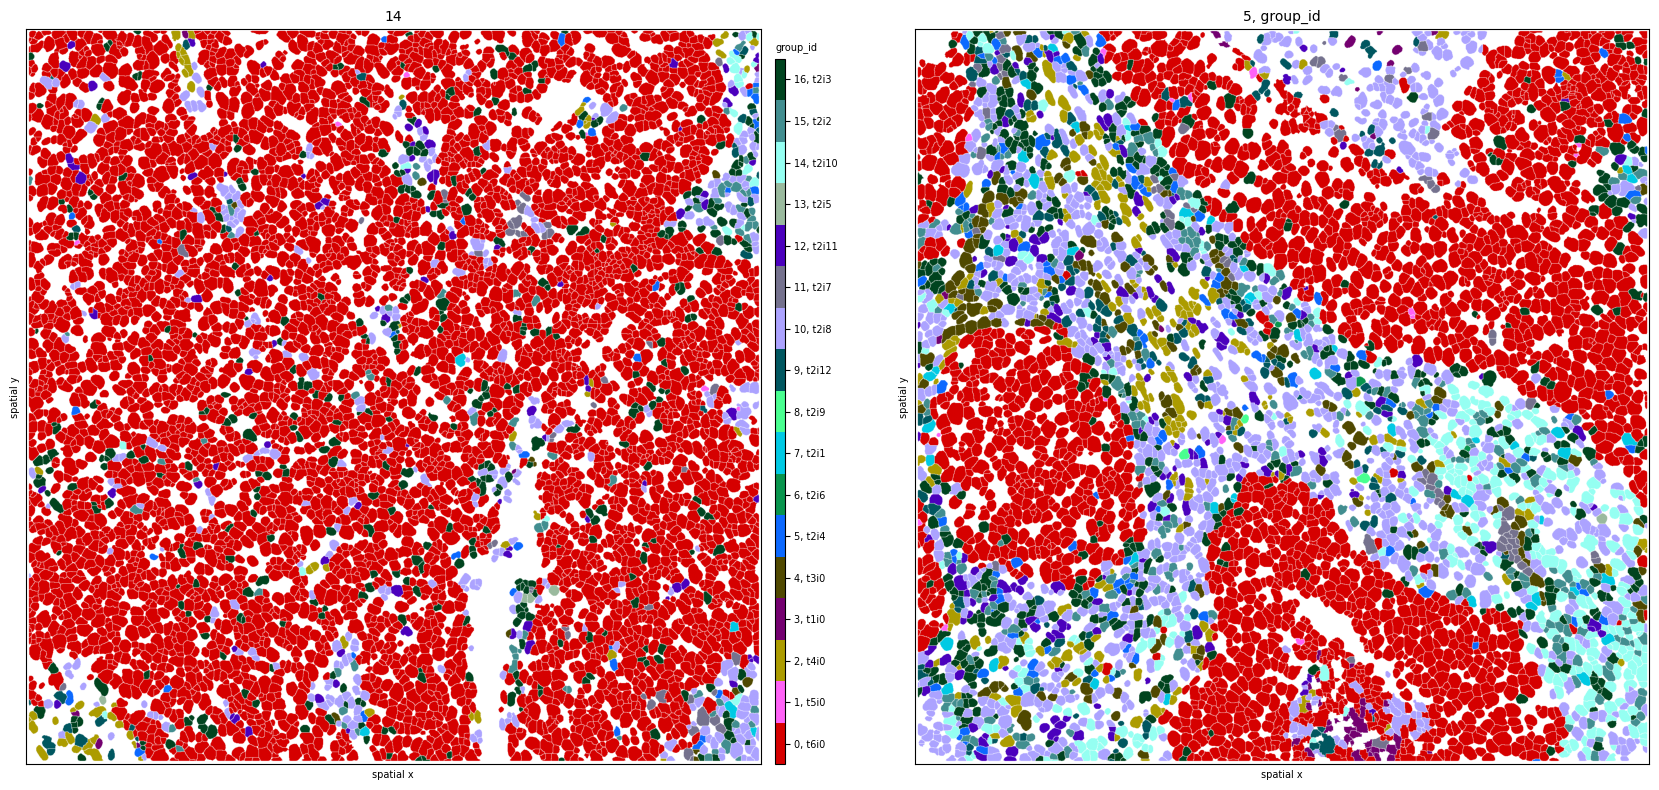

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8), dpi=100)
sh.pl.spatial(so, sel1[0], attr, mode='mask', ax=axs.flat[0])
sh.pl.spatial(so, sel2[0], attr, mode='mask', ax=axs.flat[1], cbar=False)

## Entropic measures - Observation level
Here we compute the discussed sample-level entropic measures by setting `local=True`.

In [12]:
for spl in tqdm(spls):
    sh.metrics.richness(so, spl, attr, local=True, graph_key='knn')
    sh.metrics.shannon(so, spl, attr, local=True, graph_key='knn')
    sh.metrics.quadratic_entropy(so, spl, attr, local=True, graph_key='knn', metric='cosine')

# estimated values are saved in so.obs
so.obs[spl].columns
so.obs[spl][['richness_group_id_knn', 'shannon_group_id_knn', 'quadratic_group_id_knn']].head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.82s/it]


richness_group_id_knn  shannon_group_id_knn  quadratic_group_id_knn
cell_id                                                                     
2                            1             -0.000000                0.000000
3                            1             -0.000000                0.000000
4                            1             -0.000000                0.000000
5                            1             -0.000000                0.000000
6                            2              0.863121                0.408882

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
axs = axs.flat

spl = sel1[0]
sh.pl.spatial(so, spl, attr, mode='mask', ax=axs[0])
sh.pl.spatial(so, spl, f'richness_{attr}_knn', mode='mask', ax=axs[1], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, f'shannon_{attr}_knn', mode='mask', ax=axs[2], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, f'quadratic_{attr}_knn', mode='mask', ax=axs[3], cbar_title=False, background_color='black')
spl = sel2[0]
sh.pl.spatial(so, spl, attr, mode='mask', ax=axs[4])
sh.pl.spatial(so, spl, f'richness_{attr}_knn', mode='mask', ax=axs[5], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, f'shannon_{attr}_knn', mode='mask', ax=axs[6], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, f'quadratic_{attr}_knn', mode='mask', ax=axs[7], cbar_title=False, background_color='black')

### Histogram of entropies

Text(0.5, 1.0, "Quadratic entropy, PatientID 5\n Cell-level median: 1.252, 'Sample-level: 2.833")

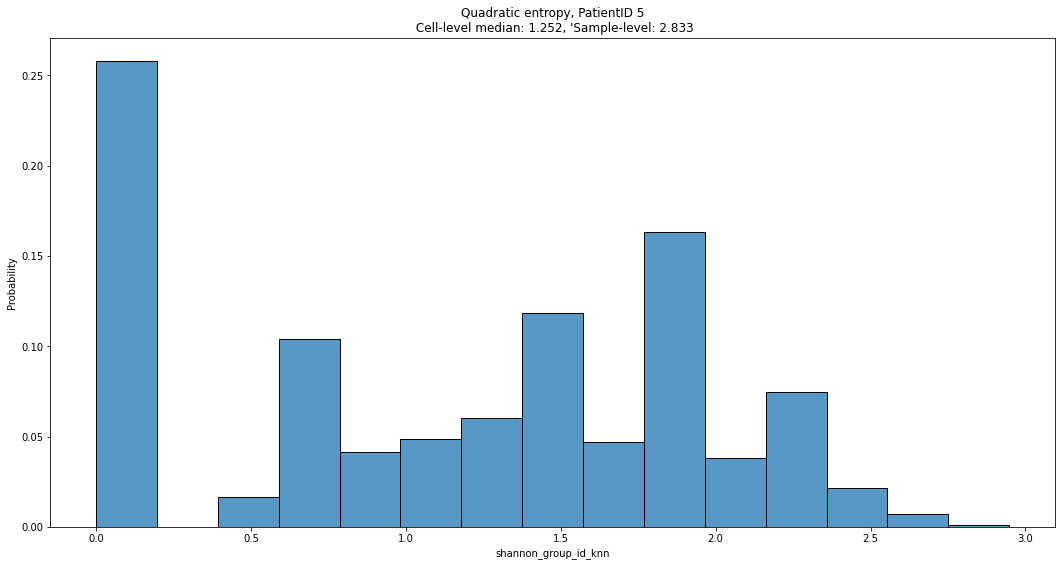

In [14]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.histplot(so.obs[spl][f'shannon_{attr}_knn'], stat='probability', ax=ax)
ax.set_title(
    f"Quadratic entropy, PatientID {spl}\n Cell-level median: {so.obs[spl][f'shannon_{attr}_knn'].median():.3f}, 'Sample-level: {so.spl.loc[spl][f'shannon_{attr}']:.3f}")

## Immune infiltration

In [15]:
for spl in spls:
    sh.neigh.infiltration(so, spl, 'cell_type', graph_key='knn')
    sh.neigh.infiltration(so, spl, 'cell_type', graph_key='radius', local=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7716/7716 [00:48<00:00, 159.24it/s]


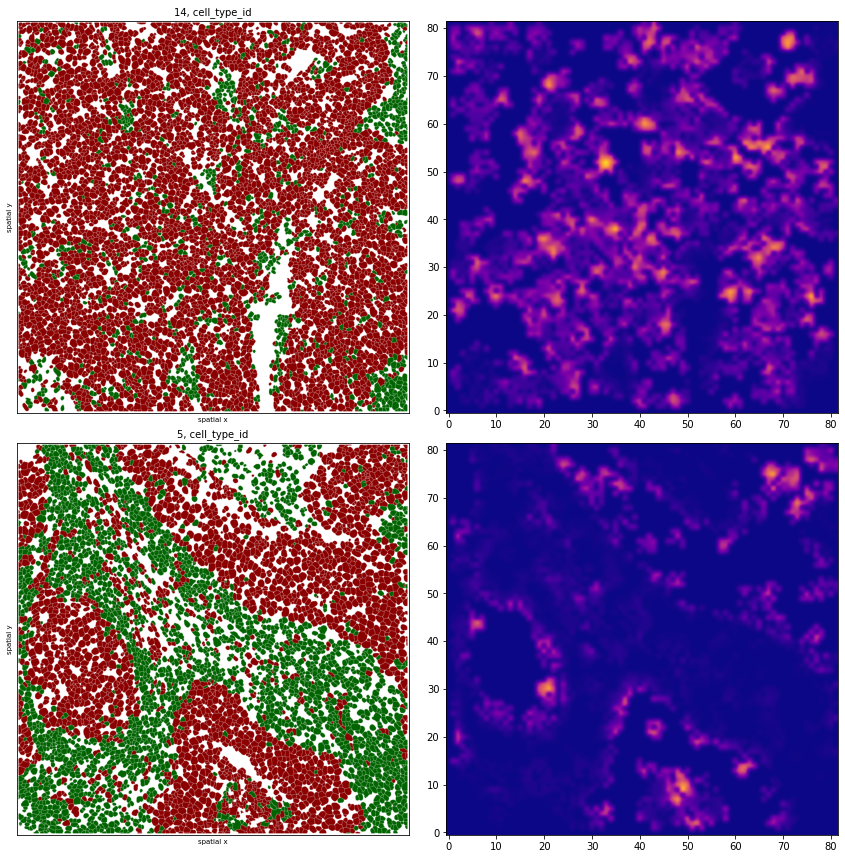

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flat

# here we use the numeric representation of cell_type to be able to plot the cell outline
sh.pl.spatial(so, sel1[0], 'cell_type_id', mode='mask', ax=axs[0], cbar=False)
sh.pl.infiltration(so, sel1[0], step_size=25, ax=axs[1])

sh.pl.spatial(so, sel2[0], 'cell_type_id', mode='mask', ax=axs[2], cbar=False)
sh.pl.infiltration(so, sel2[0], step_size=25, ax=axs[3])

## Save analysis

In [17]:
#fsave = Path('mibi-final.h5py')
#so.to_h5py(fsave)